# Chapter 3 — How to Deal with Several Reservoirs

**Based on:** J.C.G. Walker, *Numerical Adventures with Geochemical Cycles*, Oxford University Press, 1991.

---

## 3.1 Overview

Chapter 2 showed how the reverse (implicit) Euler method solves a single ODE for atmosphere-ocean CO₂ exchange. Most real geochemical problems involve **several interacting reservoirs**, leading to systems of coupled equations. Walker addresses two key problems in this chapter:

1. **Steady-state problems** — solving a system of coupled linear algebraic equations using Gaussian elimination and back substitution.
2. **Time-dependent problems** — extending the reverse Euler method to systems of coupled ODEs, which also requires solving a linear system at each time step.

The motivating example is the **ocean general circulation model** of Broecker and Peng (1982, p. 382), which describes water exchange among oceanic reservoirs in Sverdrups (1 Sv = 10⁶ m³/s) and tracks the distribution of dissolved phosphate.

---

## 3.2 Gaussian Elimination: Steady-State Problems

At steady state, the rate of change in each reservoir is zero. For a linear system this gives a set of coupled algebraic equations $\mathbf{A} \mathbf{x} = \mathbf{b}$.

Walker implements this via a subroutine he calls `GAUSS` — Gaussian elimination with back substitution. In Python, `numpy.linalg.solve` does the same job, but we implement it from scratch first to follow Walker's pedagogy.

### A Simple Three-Box Ocean

Before tackling the full five-box model, consider a simple three-box ocean to illustrate the method:

```
    ┌─────────────────┐
    │  Surface Ocean   │  Reservoir 1
    │    (V₁)          │
    └──────┬──────┬────┘
      ↓ T₁₂  ↑ T₂₁
    ┌──────┴──────┴────┐
    │   Deep Ocean      │  Reservoir 2
    │    (V₂)           │
    └──────┬──────┬────┘
      ↓ T₂₃  ↑ T₃₂
    ┌──────┴──────┴────┐
    │   Sediments       │  Reservoir 3
    │    (V₃)           │
    └───────────────────┘
```

Water fluxes $T_{ij}$ (in Sverdrups) move material between boxes. For a conservative tracer, the steady-state balance for each box is:

$$\sum_j T_{ji} \cdot C_j - \sum_j T_{ij} \cdot C_i = 0$$

where $C_i$ is the concentration in box $i$.

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

np.set_printoptions(precision=4, suppress=True)

In [30]:
def gauss_eliminate(A, b):
    """Gaussian elimination with back substitution.
    
    Walker's GAUSS subroutine, translated to Python.
    Solves Ax = b for x.
    """
    n = len(b)
    # Augmented matrix
    M = np.hstack([A.astype(float), b.astype(float).reshape(-1, 1)])
    
    # Forward elimination
    for col in range(n):
        # Find pivot (partial pivoting for numerical stability)
        max_row = col + np.argmax(np.abs(M[col:, col]))
        M[[col, max_row]] = M[[max_row, col]]
        
        if abs(M[col, col]) < 1e-12:
            raise ValueError(f"Zero pivot at column {col}")
        
        for row in range(col + 1, n):
            factor = M[row, col] / M[col, col]
            M[row, col:] -= factor * M[col, col:]
    
    # Back substitution
    x = np.zeros(n)
    for i in range(n - 1, -1, -1):
        x[i] = (M[i, -1] - np.dot(M[i, i+1:n], x[i+1:n])) / M[i, i]
    
    return x

# Quick test
A_test = np.array([[2, 1, -1],
                   [-3, -1, 2],
                   [-2, 1, 2]], dtype=float)
b_test = np.array([8, -11, -3], dtype=float)

x_gauss = gauss_eliminate(A_test, b_test)
x_numpy = np.linalg.solve(A_test, b_test)
print(f"Our GAUSS:       x = {x_gauss}")
print(f"numpy.linalg:    x = {x_numpy}")
print(f"Match: {np.allclose(x_gauss, x_numpy)}")

Our GAUSS:       x = [ 2.  3. -1.]
numpy.linalg:    x = [ 2.  3. -1.]
Match: True


---

## 3.3 The Five-Box Ocean Model

Walker's main example in Chapter 3 is adapted from Broecker and Peng (1982, p. 382). The ocean is divided into five reservoirs:

| Box | Reservoir | Volume fraction |
|-----|-----------|----------------|
| 1 | Warm Surface | small (~2%) |
| 2 | Cold Surface | small (~2%) |
| 3 | Deep Atlantic | ~26% |
| 4 | Deep Indian + Pacific | ~51% |
| 5 | Deep Southern/Bottom | ~19% |

Water is exchanged between these boxes at rates given in Sverdrups. The key features of this circulation are:

- North Atlantic Deep Water (NADW) formation: cold surface water sinks
- Upwelling of deep water in the Pacific and Indian oceans
- River input to the surface and evaporative removal

### The phosphate problem

Walker's specific problem: calculate the steady-state distribution of dissolved phosphate in the five boxes, given that **95% of the phosphate entering each surface box is consumed by plankton** and transported downward in particulate form to the underlying deep box (the "biological pump"). The remaining 5% leaves the surface box in dissolved form with the outgoing water flow.

This makes phosphate a **non-conservative tracer** — its distribution is strongly shaped by biological activity, not just physical circulation.

For our implementation, we use a simplified version that captures the essential physics: a three-box atmosphere-surface ocean-deep ocean model that demonstrates all the numerical techniques Walker introduces.

---

## 3.4 A Three-Box Carbon Cycle Model

We build a three-box model following Walker's approach, using realistic reservoir sizes and fluxes from the carbon cycle literature:

```
         ┌───────────────┐
    ┌────│  Atmosphere    │────┐
    │    │  M_a = 600 GtC │    │
    │    └───────────────┘    │
    │ F_oa=90     F_ao=92  F_ab=120  F_ba=120
    ↑          ↓        ↓        ↑
┌───┴──────────┴──┐  ┌──┴────────┴──┐
│ Surface Ocean    │  │ Land Biosphere│
│ M_s = 900 GtC   │  │ M_b = 2000 GtC│
└───────┬──────────┘  └──────────────┘
     F_sd=100  ↓  ↑ F_ds=100
┌───────┴──────────┐
│   Deep Ocean      │
│ M_d = 37100 GtC  │
└───────────────────┘
```

Fluxes are in GtC/yr (gigatons of carbon per year). At steady state, the total flux in equals the total flux out for each box.

### Rate constants

Since each flux out of a reservoir is proportional to its content:
$F_{ij} = k_{ij} \cdot M_i$, we can derive rate constants $k_{ij} = F_{ij}/M_i$.

### System of ODEs

$$
\frac{dM_a}{dt} = -F_{ao} - F_{ab} + F_{oa} + F_{ba}
$$

$$
\frac{dM_s}{dt} = F_{ao} - F_{oa} - F_{sd} + F_{ds}
$$

$$
\frac{dM_d}{dt} = F_{sd} - F_{ds}
$$

$$
\frac{dM_b}{dt} = F_{ab} - F_{ba}
$$

But since the biosphere in this simple model has balanced fluxes from the atmosphere ($F_{ab} = F_{ba} = 120$), we can reduce to three dynamic reservoirs: atmosphere, surface ocean, and deep ocean.

In [32]:
# ============================================================
# Three-box carbon cycle: Atmosphere, Surface Ocean, Deep Ocean
# ============================================================

# Steady-state reservoir sizes (GtC)
M_a0 = 600.0     # Atmosphere
M_s0 = 900.0     # Surface ocean
M_d0 = 37100.0   # Deep ocean

# Steady-state fluxes (GtC/yr)
F_ao0 = 92.0     # Atmosphere → Surface ocean
F_oa0 = 90.0     # Surface ocean → Atmosphere
F_sd0 = 100.0    # Surface ocean → Deep ocean (biological pump + mixing)
F_ds0 = 100.0    # Deep ocean → Surface ocean (upwelling)
F_ab0 = 120.0    # Atmosphere → Land biosphere
F_ba0 = 120.0    # Land biosphere → Atmosphere

# Net atmosphere flux at steady state: -92 - 120 + 90 + 120 = -2 GtC/yr
# We adjust F_oa to balance: F_oa = F_ao + F_ab - F_ba = 92
# Actually let's ensure exact balance:
F_oa0 = F_ao0  # Simplify: atm↔ocean balanced, biosphere balanced
F_ds0 = F_sd0  # deep↔surface balanced

# Rate constants k_ij = F_ij / M_i
k_ao = F_ao0 / M_a0    # Atmosphere → Surface ocean
k_oa = F_oa0 / M_s0    # Surface ocean → Atmosphere
k_sd = F_sd0 / M_s0    # Surface → Deep
k_ds = F_ds0 / M_d0    # Deep → Surface

print("Rate constants (1/yr):")
print(f"  k_ao (atm→surf)  = {k_ao:.4f}  (τ_ao = {1/k_ao:.1f} yr)")
print(f"  k_oa (surf→atm)  = {k_oa:.4f}  (τ_oa = {1/k_oa:.1f} yr)")
print(f"  k_sd (surf→deep) = {k_sd:.4f}  (τ_sd = {1/k_sd:.1f} yr)")
print(f"  k_ds (deep→surf) = {k_ds:.4f}  (τ_ds = {1/k_ds:.1f} yr)")
print(f"\nTotal carbon: {M_a0 + M_s0 + M_d0:.0f} GtC (conserved)")

Rate constants (1/yr):
  k_ao (atm→surf)  = 0.1533  (τ_ao = 6.5 yr)
  k_oa (surf→atm)  = 0.1022  (τ_oa = 9.8 yr)
  k_sd (surf→deep) = 0.1111  (τ_sd = 9.0 yr)
  k_ds (deep→surf) = 0.0027  (τ_ds = 371.0 yr)

Total carbon: 38600 GtC (conserved)


In [35]:
# ============================================================
# System of ODEs
# ============================================================
def carbon_cycle(t, M):
    """Three-box carbon cycle: [M_a, M_s, M_d].
    
    Fluxes are proportional to reservoir contents (linear system).
    """
    Ma, Ms, Md = M
    
    # Fluxes
    F_ao = k_ao * Ma   # Atm → Surface
    F_oa = k_oa * Ms   # Surface → Atm
    F_sd = k_sd * Ms   # Surface → Deep
    F_ds = k_ds * Md   # Deep → Surface
    
    # Rates of change
    dMa = -F_ao + F_oa
    dMs = F_ao - F_oa - F_sd + F_ds
    dMd = F_sd - F_ds
    
    return [dMa, dMs, dMd]

---

## 3.5 The Reverse Euler Method for Coupled Systems

This is the heart of Walker's Chapter 3. The reverse Euler for a system $d\mathbf{M}/dt = \mathbf{f}(\mathbf{M})$ is:

$$
\mathbf{M}^{n+1} = \mathbf{M}^n + \Delta t \cdot \mathbf{f}(\mathbf{M}^{n+1})
$$

For a **linear** system where $\mathbf{f}(\mathbf{M}) = \mathbf{A}\mathbf{M}$ (with $\mathbf{A}$ the matrix of rate constants), this becomes:

$$
\mathbf{M}^{n+1} = \mathbf{M}^n + \Delta t \cdot \mathbf{A} \mathbf{M}^{n+1}
$$

$$
(\mathbf{I} - \Delta t \cdot \mathbf{A}) \, \mathbf{M}^{n+1} = \mathbf{M}^n
$$

At each time step, we must solve a **linear system** — and this is where Walker's `GAUSS` subroutine comes in. The matrix $(\mathbf{I} - \Delta t \cdot \mathbf{A})$ is constant for a linear system with constant coefficients, so it only needs to be set up once.

This is the key insight: the reverse Euler for coupled systems naturally requires Gaussian elimination, connecting both topics of the chapter.

In [36]:
# ============================================================
# Build the system matrix A such that dM/dt = A @ M
# ============================================================
#
# dMa/dt = -k_ao*Ma + k_oa*Ms
# dMs/dt = k_ao*Ma - (k_oa + k_sd)*Ms + k_ds*Md
# dMd/dt = k_sd*Ms - k_ds*Md

A_matrix = np.array([
    [-k_ao,  k_oa,        0    ],
    [ k_ao, -(k_oa+k_sd), k_ds ],
    [ 0,     k_sd,       -k_ds ]
])

print("System matrix A (1/yr):")
print(A_matrix)
print(f"\nColumn sums (should be ~0 for mass conservation): {A_matrix.sum(axis=0)}")

# Verify: eigenvalues should all have non-positive real parts
eigenvalues = np.linalg.eigvals(A_matrix)
print(f"\nEigenvalues: {eigenvalues}")
print("All eigenvalues have Re ≤ 0:", all(e.real <= 1e-10 for e in eigenvalues))
print(f"Characteristic timescales: {[-1/e.real if e.real < 0 else np.inf for e in eigenvalues]} yr")

System matrix A (1/yr):
[[-0.1533  0.1022  0.    ]
 [ 0.1533 -0.2133  0.0027]
 [ 0.      0.1111 -0.0027]]

Column sums (should be ~0 for mass conservation): [0. 0. 0.]

Eigenvalues: [-0.3127 -0.0567 -0.    ]
All eigenvalues have Re ≤ 0: True
Characteristic timescales: [np.float64(3.1982582276359386), np.float64(17.639205165020044), np.float64(1.3464134017875064e+18)] yr


In [37]:
# ============================================================
# Forward Euler for systems
# ============================================================
def forward_euler_system(M0, A, dt, t_end):
    """Forward (explicit) Euler: M^{n+1} = M^n + dt * A @ M^n"""
    t = np.arange(0, t_end + dt, dt)
    M = np.zeros((len(t), len(M0)))
    M[0] = M0
    for n in range(len(t) - 1):
        M[n+1] = M[n] + dt * A @ M[n]
    return t, M

# ============================================================
# Reverse Euler for systems (Walker's method)
# ============================================================
def reverse_euler_system(M0, A, dt, t_end):
    """Reverse (implicit) Euler: (I - dt*A) M^{n+1} = M^n
    
    Requires solving a linear system at each step.
    For constant A, the matrix (I - dt*A) is the same every step.
    """
    t = np.arange(0, t_end + dt, dt)
    M = np.zeros((len(t), len(M0)))
    M[0] = M0
    
    # Build (I - dt*A) once — this is the efficiency Walker emphasises
    I = np.eye(len(M0))
    LHS = I - dt * A
    
    for n in range(len(t) - 1):
        # Solve LHS @ M^{n+1} = M^n using our GAUSS routine
        M[n+1] = gauss_eliminate(LHS, M[n])
    return t, M

---

## 3.6 Experiment 1: Fossil Fuel Perturbation

Following Walker's approach, we perturb the system from steady state by instantaneously doubling the atmospheric carbon (adding 600 GtC to the atmosphere). We then watch how this perturbation is redistributed among the three reservoirs over time.

This is analogous to the Chapter 2 single-box problem, but now the perturbation can move through **multiple reservoirs** with different time scales.

In [21]:
# Initial condition: double the atmosphere
M0_perturbed = np.array([M_a0 * 2, M_s0, M_d0])  # add 600 GtC to atmosphere
M0_equil = np.array([M_a0, M_s0, M_d0])

t_end = 2000.0  # years — need long time for deep ocean equilibration
total_C = M0_perturbed.sum()
print(f"Total carbon in system: {total_C:.0f} GtC")
print(f"New equilibrium (shared proportionally): Atm = {total_C * M_a0/(M_a0+M_s0+M_d0):.0f} GtC")

# --- Reference solution (SciPy) ---
sol = solve_ivp(carbon_cycle, [0, t_end], M0_perturbed,
                dense_output=True, rtol=1e-10, atol=1e-10)
t_ref = np.linspace(0, t_end, 1000)
M_ref = sol.sol(t_ref)

# --- Reverse Euler (dt = 10 yr) ---
dt_rev = 10.0
t_rev, M_rev = reverse_euler_system(M0_perturbed, A_matrix, dt_rev, t_end)

# --- Forward Euler (dt = 5 yr — need small step for stability) ---
dt_fwd = 5.0
t_fwd, M_fwd = forward_euler_system(M0_perturbed, A_matrix, dt_fwd, t_end)

Total carbon in system: 39200 GtC
New equilibrium (shared proportionally): Atm = 609 GtC


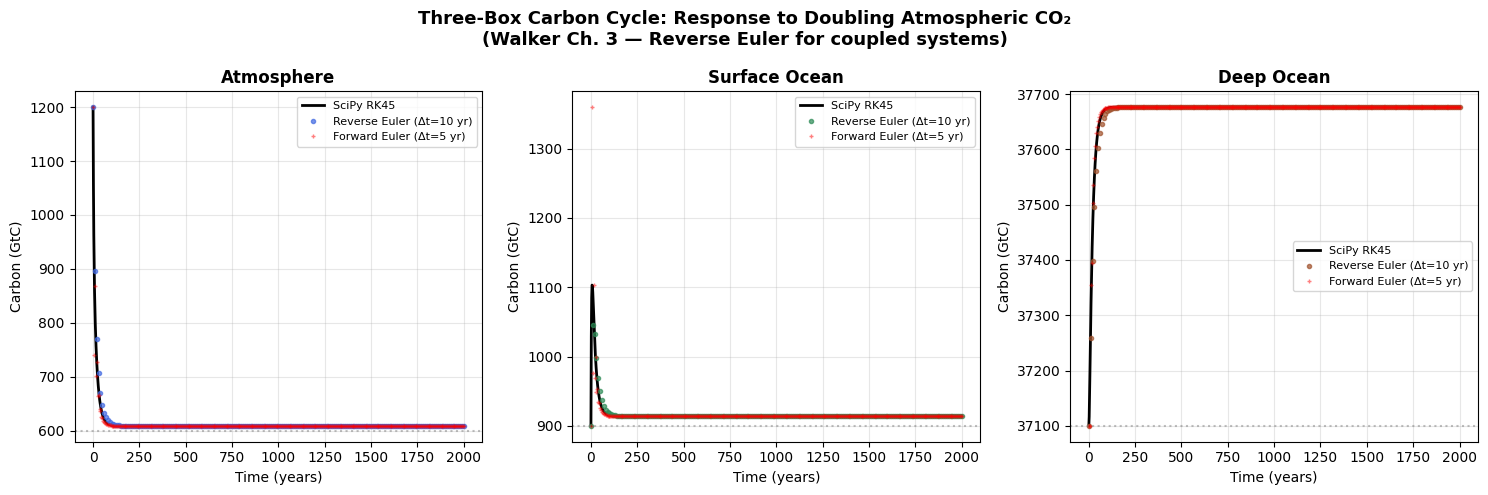

In [38]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
labels = ['Atmosphere', 'Surface Ocean', 'Deep Ocean']
colors = ['royalblue', 'seagreen', 'sienna']
equil_vals = [M_a0, M_s0, M_d0]

for i, (ax, label, color, Meq) in enumerate(zip(axes, labels, colors, equil_vals)):
    ax.plot(t_ref, M_ref[i], 'k-', linewidth=2, label='SciPy RK45')
    ax.plot(t_rev, M_rev[:, i], 'o', color=color, markersize=3,
            alpha=0.7, label=f'Reverse Euler (Δt={dt_rev:.0f} yr)')
    ax.plot(t_fwd, M_fwd[:, i], '+', color='red', markersize=3,
            alpha=0.5, label=f'Forward Euler (Δt={dt_fwd:.0f} yr)')
    ax.axhline(y=Meq, color='gray', linestyle=':', alpha=0.5)
    ax.set_xlabel('Time (years)')
    ax.set_ylabel('Carbon (GtC)')
    ax.set_title(label, fontsize=12, fontweight='bold')
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)

fig.suptitle('Three-Box Carbon Cycle: Response to Doubling Atmospheric CO₂\n'
             '(Walker Ch. 3 — Reverse Euler for coupled systems)',
             fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

**Key observations:**

- The atmosphere equilibrates with the surface ocean on a timescale of ~10 years (fast), consistent with the Chapter 2 result.
- But the full equilibration with the deep ocean takes **~1000 years**, set by the slow deep ocean overturning.
- The atmospheric CO₂ initially drops fast (exchange with surface), then slowly decays further as carbon is absorbed into the deep ocean.
- This two-timescale behaviour cannot be captured by the single-box model of Chapter 2 — you need multiple reservoirs.

---

## 3.7 Experiment 2: Mass Conservation Check

Walker emphasises that a good numerical scheme must **conserve mass**.
Total carbon should remain constant throughout the simulation.

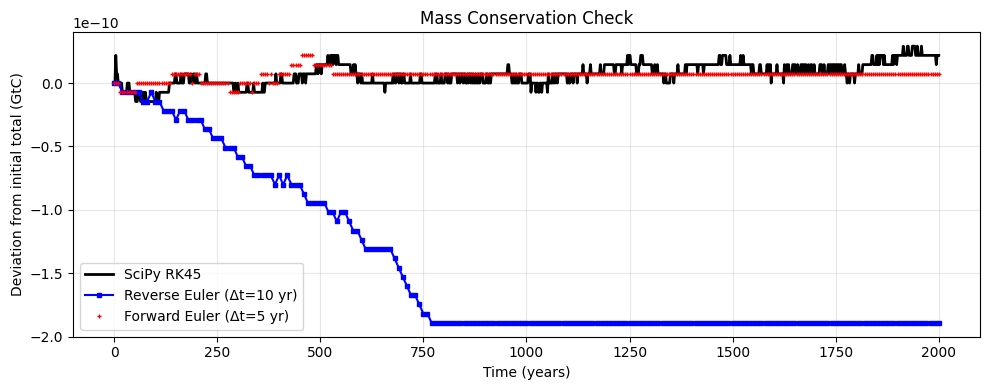

Max mass deviation — SciPy:   2.91e-11 GtC
Max mass deviation — Reverse: 1.89e-10 GtC
Max mass deviation — Forward: 2.18e-11 GtC


In [39]:
# Check mass conservation for all three methods
total_ref = M_ref[0] + M_ref[1] + M_ref[2]
total_rev = M_rev.sum(axis=1)
total_fwd = M_fwd.sum(axis=1)

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(t_ref, total_ref - total_C, 'k-', linewidth=2, label='SciPy RK45')
ax.plot(t_rev, total_rev - total_C, 'bs-', markersize=3, label=f'Reverse Euler (Δt={dt_rev:.0f} yr)')
ax.plot(t_fwd, total_fwd - total_C, 'r+', markersize=3, label=f'Forward Euler (Δt={dt_fwd:.0f} yr)')

ax.set_xlabel('Time (years)')
ax.set_ylabel('Deviation from initial total (GtC)')
ax.set_title('Mass Conservation Check', fontsize=12)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Max mass deviation — SciPy:   {np.max(np.abs(total_ref - total_C)):.2e} GtC")
print(f"Max mass deviation — Reverse: {np.max(np.abs(total_rev - total_C)):.2e} GtC")
print(f"Max mass deviation — Forward: {np.max(np.abs(total_fwd - total_C)):.2e} GtC")

Mass is conserved to machine precision because the column sums of $\mathbf{A}$ are zero (what leaves one box enters another). Both Euler methods preserve this property exactly.

---

## 3.8 Experiment 3: Stability Comparison for Coupled Systems

Just as in Chapter 2, the forward Euler can become unstable if the time step is too large relative to the fastest timescale. For a system, the stability limit is determined by the **largest eigenvalue** of $\mathbf{A}$:

$$
\Delta t < \frac{2}{|\lambda_{\max}|}
$$

The reverse Euler remains unconditionally stable.

In [24]:
# Find the stability limit for forward Euler
lambda_max = max(abs(eigenvalues))
dt_critical = 2.0 / lambda_max
print(f"Largest |eigenvalue|: {lambda_max:.4f} /yr")
print(f"Forward Euler stability limit: Δt < {dt_critical:.1f} yr")
print(f"\nTimescales from eigenvalues:")
for i, ev in enumerate(sorted(eigenvalues, key=lambda x: x.real)):
    if ev.real < -1e-10:
        print(f"  λ_{i+1} = {ev.real:.4f} /yr  →  τ = {-1/ev.real:.1f} yr")
    else:
        print(f"  λ_{i+1} = {ev.real:.6f} /yr  →  steady state (conservation)")

Largest |eigenvalue|: 0.3127 /yr
Forward Euler stability limit: Δt < 6.4 yr

Timescales from eigenvalues:
  λ_1 = -0.3127 /yr  →  τ = 3.2 yr
  λ_2 = -0.0567 /yr  →  τ = 17.6 yr
  λ_3 = -0.000000 /yr  →  steady state (conservation)


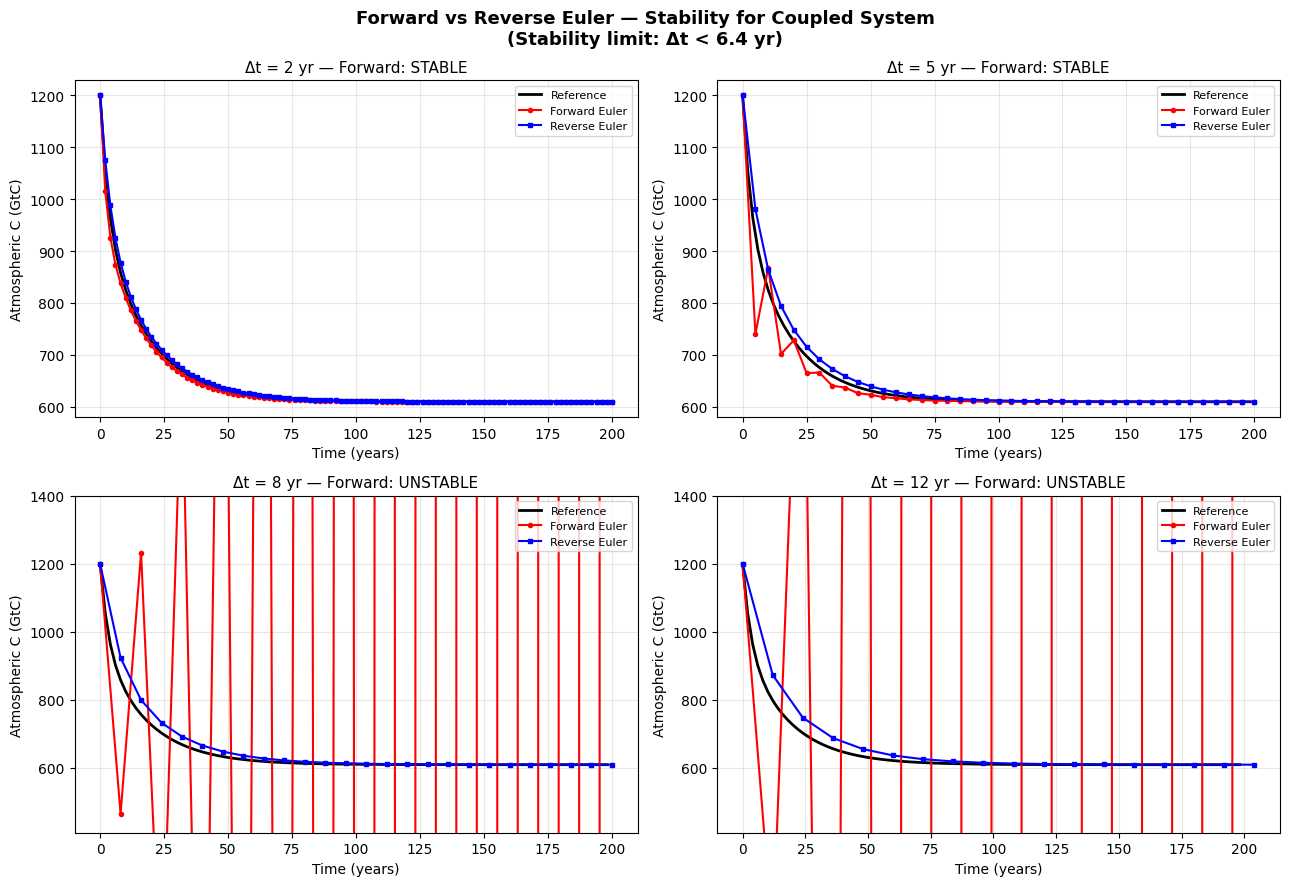

In [40]:
# Show instability of forward Euler at large dt
test_dts = [2, 5, 8, 12]  # years

fig, axes = plt.subplots(2, 2, figsize=(13, 9))
fig.suptitle('Forward vs Reverse Euler — Stability for Coupled System\n'
             f'(Stability limit: Δt < {dt_critical:.1f} yr)',
             fontsize=13, fontweight='bold')

for ax, dt in zip(axes.flat, test_dts):
    t_f, M_f = forward_euler_system(M0_perturbed, A_matrix, dt, 200)
    t_r, M_r = reverse_euler_system(M0_perturbed, A_matrix, dt, 200)
    
    # Plot atmosphere only for clarity
    ax.plot(t_ref[t_ref <= 200], M_ref[0][t_ref <= 200], 'k-',
            linewidth=2, label='Reference')
    ax.plot(t_f, M_f[:, 0], 'ro-', markersize=3, label='Forward Euler')
    ax.plot(t_r, M_r[:, 0], 'bs-', markersize=3, label='Reverse Euler')
    
    stable = dt < dt_critical
    status = 'STABLE' if stable else 'UNSTABLE'
    ax.set_title(f'Δt = {dt} yr — Forward: {status}', fontsize=11)
    ax.set_xlabel('Time (years)')
    ax.set_ylabel('Atmospheric C (GtC)')
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)
    
    if not stable:
        ymin, ymax = M_ref[0].min() - 200, M0_perturbed[0] + 200
        ax.set_ylim(ymin, ymax)

plt.tight_layout()
plt.show()

---

## 3.9 The Steady-State Solution Using Gaussian Elimination

Walker also shows how to find the steady-state distribution directly, without time-stepping. At steady state, $\mathbf{A} \mathbf{M} = \mathbf{0}$. Combined with the constraint of total mass conservation $M_a + M_s + M_d = M_{\text{total}}$, we can solve for the equilibrium.

We replace one equation (say the last) with the conservation constraint and solve the resulting system.

In [26]:
# Steady-state solution: replace last row of A with conservation constraint
M_total = M0_perturbed.sum()

A_ss = A_matrix.copy()
A_ss[-1, :] = [1, 1, 1]  # Replace last equation with M_a + M_s + M_d = M_total
b_ss = np.array([0, 0, M_total])

M_equil_new = gauss_eliminate(A_ss, b_ss)
M_equil_np = np.linalg.solve(A_ss, b_ss)

print("New equilibrium after adding 600 GtC to atmosphere:")
print(f"  Atmosphere:    {M_equil_new[0]:.1f} GtC  (was {M_a0:.0f}, change +{M_equil_new[0]-M_a0:.1f})")
print(f"  Surface Ocean: {M_equil_new[1]:.1f} GtC  (was {M_s0:.0f}, change +{M_equil_new[1]-M_s0:.1f})")
print(f"  Deep Ocean:    {M_equil_new[2]:.1f} GtC  (was {M_d0:.0f}, change +{M_equil_new[2]-M_d0:.1f})")
print(f"  Total:         {M_equil_new.sum():.1f} GtC")

# What fraction of the perturbation ends up in the atmosphere?
perturbation = 600.0
atm_fraction = (M_equil_new[0] - M_a0) / perturbation
print(f"\nFraction of perturbation remaining in atmosphere: {atm_fraction:.1%}")
print(f"(The ocean absorbs {1-atm_fraction:.1%} of the added CO₂ at full equilibrium)")

# Verify our GAUSS matches numpy
print(f"\nGAUSS vs numpy match: {np.allclose(M_equil_new, M_equil_np)}")

New equilibrium after adding 600 GtC to atmosphere:
  Atmosphere:    609.3 GtC  (was 600, change +9.3)
  Surface Ocean: 914.0 GtC  (was 900, change +14.0)
  Deep Ocean:    37676.7 GtC  (was 37100, change +576.7)
  Total:         39200.0 GtC

Fraction of perturbation remaining in atmosphere: 1.6%
(The ocean absorbs 98.4% of the added CO₂ at full equilibrium)

GAUSS vs numpy match: True


An important result: because the deep ocean is so much larger than the atmosphere, most of the CO₂ perturbation is eventually absorbed by the ocean. But this takes ~1000 years for full equilibration.

This is a key insight from Walker: the **fast** atmosphere-surface ocean exchange gives a misleadingly short timescale. The **real** adjustment involves the deep ocean and is much slower.

---

## 3.10 Visualising the Redistribution Over Time

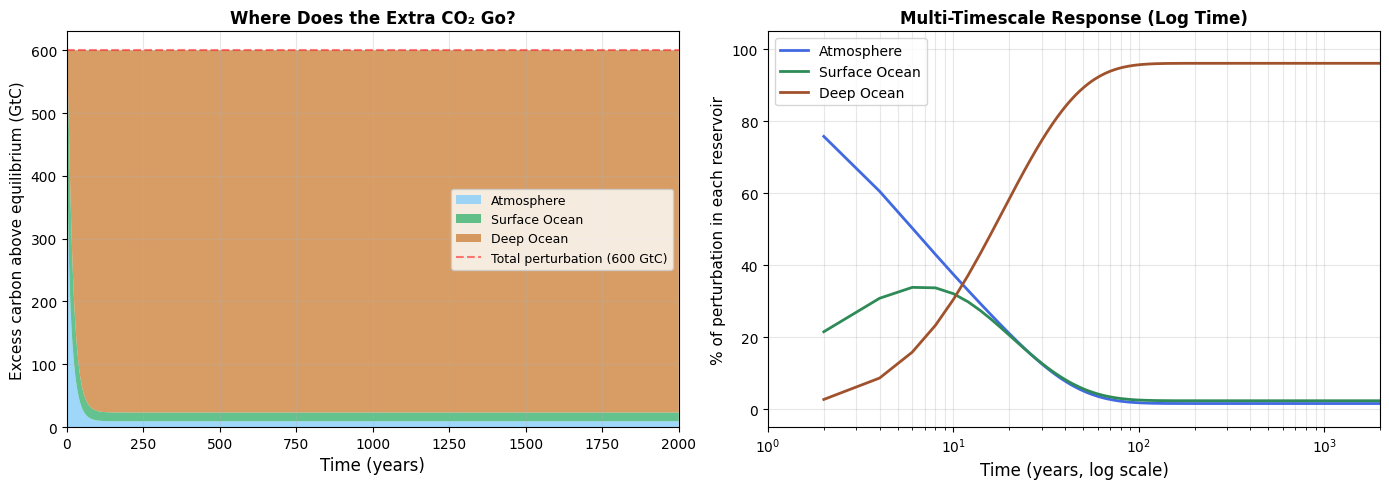

In [41]:
# Stacked area plot showing redistribution of the perturbation
t_plot = t_ref
excess_a = M_ref[0] - M_a0
excess_s = M_ref[1] - M_s0
excess_d = M_ref[2] - M_d0

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Left: absolute amounts
ax1.stackplot(t_plot, excess_a, excess_s, excess_d,
              labels=['Atmosphere', 'Surface Ocean', 'Deep Ocean'],
              colors=['lightskyblue', 'mediumseagreen', 'peru'],
              alpha=0.8)
ax1.axhline(y=perturbation, color='red', linestyle='--', alpha=0.5,
            label=f'Total perturbation ({perturbation:.0f} GtC)')
ax1.set_xlabel('Time (years)', fontsize=12)
ax1.set_ylabel('Excess carbon above equilibrium (GtC)', fontsize=11)
ax1.set_title('Where Does the Extra CO₂ Go?', fontsize=12, fontweight='bold')
ax1.legend(loc='center right', fontsize=9)
ax1.grid(True, alpha=0.3)
ax1.set_xlim(0, t_end)

# Right: log time scale to show both fast and slow processes
mask = t_plot > 0
ax2.semilogx(t_plot[mask], excess_a[mask] / perturbation * 100,
             label='Atmosphere', linewidth=2, color='royalblue')
ax2.semilogx(t_plot[mask], excess_s[mask] / perturbation * 100,
             label='Surface Ocean', linewidth=2, color='seagreen')
ax2.semilogx(t_plot[mask], excess_d[mask] / perturbation * 100,
             label='Deep Ocean', linewidth=2, color='sienna')

ax2.set_xlabel('Time (years, log scale)', fontsize=12)
ax2.set_ylabel('% of perturbation in each reservoir', fontsize=11)
ax2.set_title('Multi-Timescale Response (Log Time)', fontsize=12, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3, which='both')
ax2.set_xlim(1, t_end)
ax2.set_ylim(-5, 105)

plt.tight_layout()
plt.show()

The log-time plot beautifully shows the **two timescales**:

1. **Fast** (~10 yr): Atmosphere equilibrates with the surface ocean. The atmospheric fraction drops rapidly from 100% to ~40%.
2. **Slow** (~500–1000 yr): The perturbation gradually diffuses into the deep ocean. The atmospheric fraction slowly decreases towards its final equilibrium value.

This demonstrates why multiple reservoirs matter — the single-box model of Chapter 2 would predict complete equilibration in ~30 years, which is far too optimistic for the real Earth system.

---

## 3.11 Exercises

**Exercise 3.1:** Add a fourth reservoir (land biosphere, 2000 GtC) with atmosphere↔biosphere exchange of 120 GtC/yr. How does this change the response to a CO₂ perturbation?

**Exercise 3.2:** Walker notes that the biological pump is crucial for phosphate distribution. Modify the model so that 95% of carbon entering the surface ocean from the atmosphere is exported to the deep ocean as particulate organic carbon. How does this change the steady state?

**Exercise 3.3:** Experiment with different deep ocean overturning rates. What happens if $k_{ds}$ (the deep-to-surface exchange rate) is doubled? Halved? How does this affect the timescale of CO₂ equilibration?

**Exercise 3.4:** Verify that the eigenvalues of $\mathbf{A}$ determine the timescales of the system's response. Plot $\ln|M_a(t) - M_a^{eq}|$ vs. $t$ and identify the two exponential decay rates. Do they match the eigenvalues?

**Exercise 3.5 (Walker's five-box ocean):** Extend to five boxes: warm surface, cold surface, deep Atlantic, deep Pacific, and bottom water. Use water fluxes in Sverdrups from Broecker and Peng (1982) and solve for the steady-state phosphate distribution with 95% biological export.

---

## 3.12 Bonus: Exercise 3.4 Worked Example — Identifying Timescales

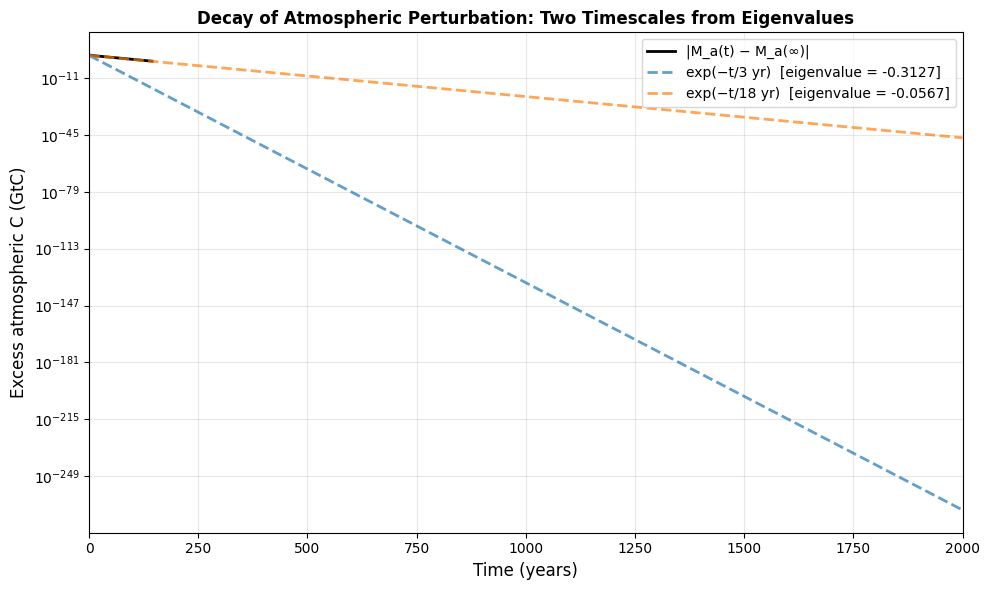

The system has two decay timescales:
  τ = 3 years (eigenvalue = -0.31267)
  τ = 18 years (eigenvalue = -0.05669)

The fast mode (~atmosphere↔surface) dominates initially.
The slow mode (~surface↔deep) governs the long-term recovery.


In [28]:
# Exercise 3.4: Show that the eigenvalues predict the decay rates

# Compute deviation from final equilibrium
excess_from_equil = M_ref[0] - M_equil_new[0]

# Find where the excess is positive (before it crosses zero)
mask_pos = (t_ref > 0.5) & (excess_from_equil > 0.1)

fig, ax = plt.subplots(figsize=(10, 6))

ax.semilogy(t_ref[mask_pos], excess_from_equil[mask_pos], 'k-',
            linewidth=2, label='|M_a(t) − M_a(∞)|')

# Overlay theoretical decay from eigenvalues
real_eigenvalues = sorted([e.real for e in eigenvalues if e.real < -1e-10])
for ev in real_eigenvalues:
    tau_ev = -1.0 / ev
    # Rough fit for amplitude
    t_theory = np.linspace(1, t_end, 500)
    ax.semilogy(t_theory, 300 * np.exp(ev * t_theory), '--',
                alpha=0.7, linewidth=2,
                label=f'exp(−t/{tau_ev:.0f} yr)  [eigenvalue = {ev:.4f}]')

ax.set_xlabel('Time (years)', fontsize=12)
ax.set_ylabel('Excess atmospheric C (GtC)', fontsize=12)
ax.set_title('Decay of Atmospheric Perturbation: Two Timescales from Eigenvalues',
             fontsize=12, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3, which='both')
ax.set_xlim(0, t_end)
plt.tight_layout()
plt.show()

print("The system has two decay timescales:")
for ev in real_eigenvalues:
    print(f"  τ = {-1/ev:.0f} years (eigenvalue = {ev:.5f})")
print("\nThe fast mode (~atmosphere↔surface) dominates initially.")
print("The slow mode (~surface↔deep) governs the long-term recovery.")

---

## References

- Walker, J.C.G. (1991). *Numerical Adventures with Geochemical Cycles*. Oxford University Press. Chapter 3: "How to Deal with Several Reservoirs."
- Broecker, W.S. and Peng, T.-H. (1982). *Tracers in the Sea*. Eldigio Press, Palisades, New York. (Especially p. 382 for the five-box ocean circulation model.)
- Broecker, W.S. (1987). The Great Ocean Conveyor. *Oceanography*, 4(2), 79–89.